# ECE4450J Final Project: Unsupervised Image Clustering on Digital Handwritten Digits

Group: 
- Ersin Mete Borst 721370990005
- Joven Laurens Nicholas 520370990035
- Zack Hongming Zhang 721370990001

Import library

In [88]:
import torch
import torchvision
import math
import numpy as np

from matplotlib import pyplot as plt
from sklearn.metrics.cluster import pair_confusion_matrix
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

# Import local files
from model import Model
from kmeans import KMeans
from pca import PCA

## Data set: MNIST

In [121]:
DOWNLOAD_DATASET = True

transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the PIL Image to a PyTorch tensor
    transforms.Normalize((0,), (1,))
])

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        noisy_tensor = tensor + \
            torch.randn(tensor.size()) * self.std + self.mean
        return torch.clamp(noisy_tensor, 0., 1.)

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

# Compose the transformations
transform_blur = transforms.Compose([
    transforms.CenterCrop(28), 
    transforms.GaussianBlur(3),
    AddGaussianNoise(0., 0.1),
])

train_data = torchvision.datasets.MNIST(
    root='./../data',
    train=True,
    download=DOWNLOAD_DATASET,
    transform=transform
)

test_data = torchvision.datasets.MNIST(
    root='./../data',
    train=False,
    download=DOWNLOAD_DATASET,
    transform=transform
)

## Autoencoder: Convoluted Neural Network

### Load data loader

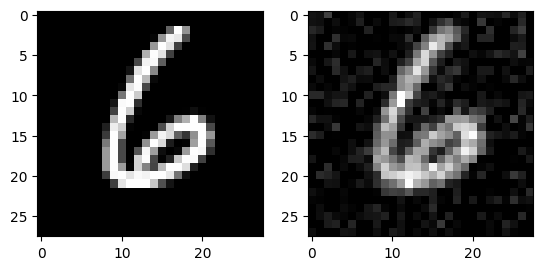

In [175]:
batch_size = 128

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

img, _ = next(iter(train_loader))
blur_img = transform_blur(img[0])

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(img[0].detach().numpy().reshape(28,28), cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(blur_img[0].detach().numpy().reshape(28, 28), cmap='gray')
plt.show()

### Train or load model

In [169]:
train = False  # Need to change to True if you want to train the model

num_epochs = 10

PATH = './../model/model.pth'

model = Model()

criterion = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3,
                             weight_decay=1e-8)

if train == True:
    writer = SummaryWriter()
    total_step = len(train_loader)
    interval = math.ceil(len(train_loader) / 5)
    
    for epoch in range(num_epochs):
        for i, data in enumerate(train_loader, 0):
            img, _ = data
            blur_img = transform_blur(img)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            output = model(blur_img)
            loss = criterion(output, img)
            loss.backward()
            optimizer.step()
            if i % interval == 0:
                writer.add_scalar('Loss/train', loss,
                                  epoch * total_step + i)
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch + 1, i * len(
                    inputs), len(train_loader.dataset), 100. * i / len(train_loader), loss.item()))
    writer.close()
    model.save(PATH)
else:
    # Load the model
    model.load(PATH)

### Model evaluation

Extracting features from the encoder

In [170]:
all_features = [] 
true_labels = [] 

with torch.no_grad():
    for i, data in enumerate(test_loader,0):
        img, labels = data
        outputs = model.extract_features(img)
        outputs = outputs.reshape(outputs.shape[0], -1)
        feature = outputs.detach().numpy()
        all_features.append(feature[0])
        true_labels.append(labels[0])

true_labels = np.array(true_labels)
all_features = np.array(all_features)
print(all_features.shape)
print(true_labels.shape)


(10000, 256)
(10000,)


Decoding the features

(1, 28, 28)


ValueError: num must be an integer with 1 <= num <= 10, not 11

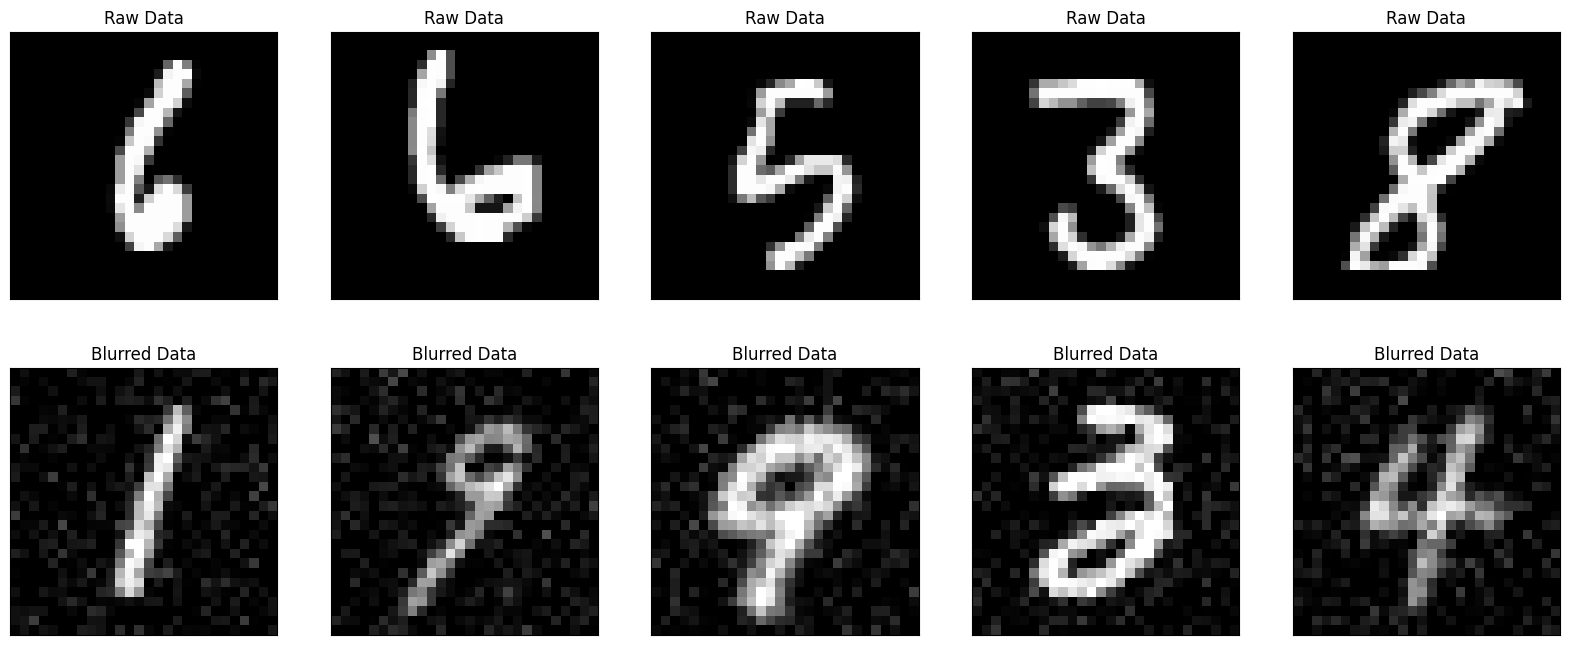

In [179]:
all_decoded = []
all_blur = []
all_img = []
n = 5

with torch.no_grad():
    for i, data in enumerate(train_loader, 0):
        if i == n:
            break
        img, _ = data
        blur_img = transform_blur(img)
        outputs = model.forward(blur_img)
        all_decoded.append(outputs[0].detach().numpy())
        all_img.append(img[0].detach().numpy())
        all_blur.append(blur_img[0].detach().numpy())
        

print(all_decoded[0].shape)
plt.figure(figsize=(40, 8))

for i in range(n):
    # define subplot
    ax = plt.subplot(2, n , 1 + i)
    plt.imshow(all_raw[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Raw Data')
    
    ax = plt.subplot(2, n, 1 + i + n)
    plt.imshow(all_blur[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Blurred Data')
    
    ax = plt.subplot(2, n, 1 + i + n + 1)
    plt.imshow(all_decoded[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Decoded Data')

plt.show()

## Clustering: K-means and PCA

### K-means clustering

In [171]:
features = np.array(all_features)
kmeans = KMeans(n_clusters=10)
kmeans.fit(features)
labels = kmeans.predict(features)

### Adjusted Rand Index

In [172]:
def rand_index_score(labels_true, labels_pred):
    (tn, fp), (fn, tp) = pair_confusion_matrix(labels_true, labels_pred)
    tn, fp, fn, tp = int(tn), int(fp), int(fn), int(tp)
    if fn == 0 and fp == 0:
        return 1.0
    return 2.0 * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) + (tp + fp) * (fp + tn))

print(labels.shape)
print(true_labels.shape)
ari = rand_index_score(labels, true_labels)
print(f'Adjusted Rand Index: {ari:.2f}')

(10000,)
(10000,)
Adjusted Rand Index: 0.44


### PCA for dimensionality reduction and visualization

In [173]:
# Reduceed the dimensionality of the data using PCA
pca = PCA(n_components=2)
x_pca = pca.fit_transform(features)

### Visualization

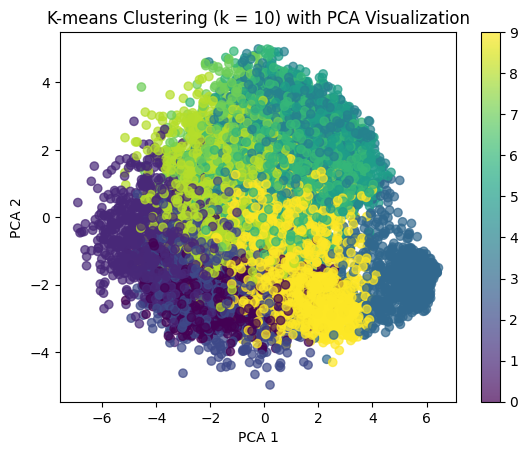

In [174]:
# Plot the clustered data in 2D
plt.scatter(x_pca[:, 0], x_pca[:, 1],
            c=labels, cmap='viridis', alpha=0.7)
plt.title('K-means Clustering (k = 10) with PCA Visualization')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar()
plt.show()